In [33]:
import torch
from torch import nn
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from IPython import display

import torchvision
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if you have one

## You may need to pip3 install ipywidgets for this notebook to work

#### Diffusion models

We want to learn a generative model or distribution over data $x$. In the context of robotics this may be a behaviour cloning policy over some control actions, a human behaviour model, or a dynamics/ reward model. In the image generation case, this is a model that can produce realistic looking images.

Assume we have a set of samples from a real data distribution:

$$x_0 \sim q(x)$$


How can we approximate this distribution? We already have a few ways. Implicit generative modelling approaches like GANs learn to generate synthetic samples that look like real-world samples, by learning to confuse a classifier that is learning to tell these apart. If this sounds clunky it's because it is, and ideally we'd love a more direct, likelihood-based approach. Flows (invertible transforms of distributions) and variational autoencoding (fitting a latent variable model to maximise a variational lower bound) fall into this category, with nice principled justifications and training mechanisms, but unfortunately have never quite performed as well as GANs at high dimensional generative modelling. Diffusion models [(Sohl-Dickstein et al. 2015)](https://arxiv.org/abs/1503.03585) remedy this, providing excellent generative modelling performance, and an explicit likelihood based probabilistic formulation.

#### Forward process

Let's imagine a foward process, where we repeatedly add Gaussian noise to our original sample $x_0$, over a series of $T$ steps, to produce a sequence of noisy samples $x_1,\ldots,x_T$. We'll do this with a *diffusion process*

$$q (x_t|x_{t-1}) = \mathcal{N}(x_t|\sqrt{1-\beta_t}x_{t-1},\beta_t)$$

This has a joint distribution

$$q(x_{1:T}|x_0) = \prod_{t=1}^{T} q (x_t|x_{t-1}) $$

These steps are controlled by a variance schedule $\{\beta_t \in (0,1) \}^T_{t=1}$. As more steps are taken, the sample $x_0$ loses it's distinquishing structure until it is eventually overwhelmed by noise, and follows a Gaussian distribution.

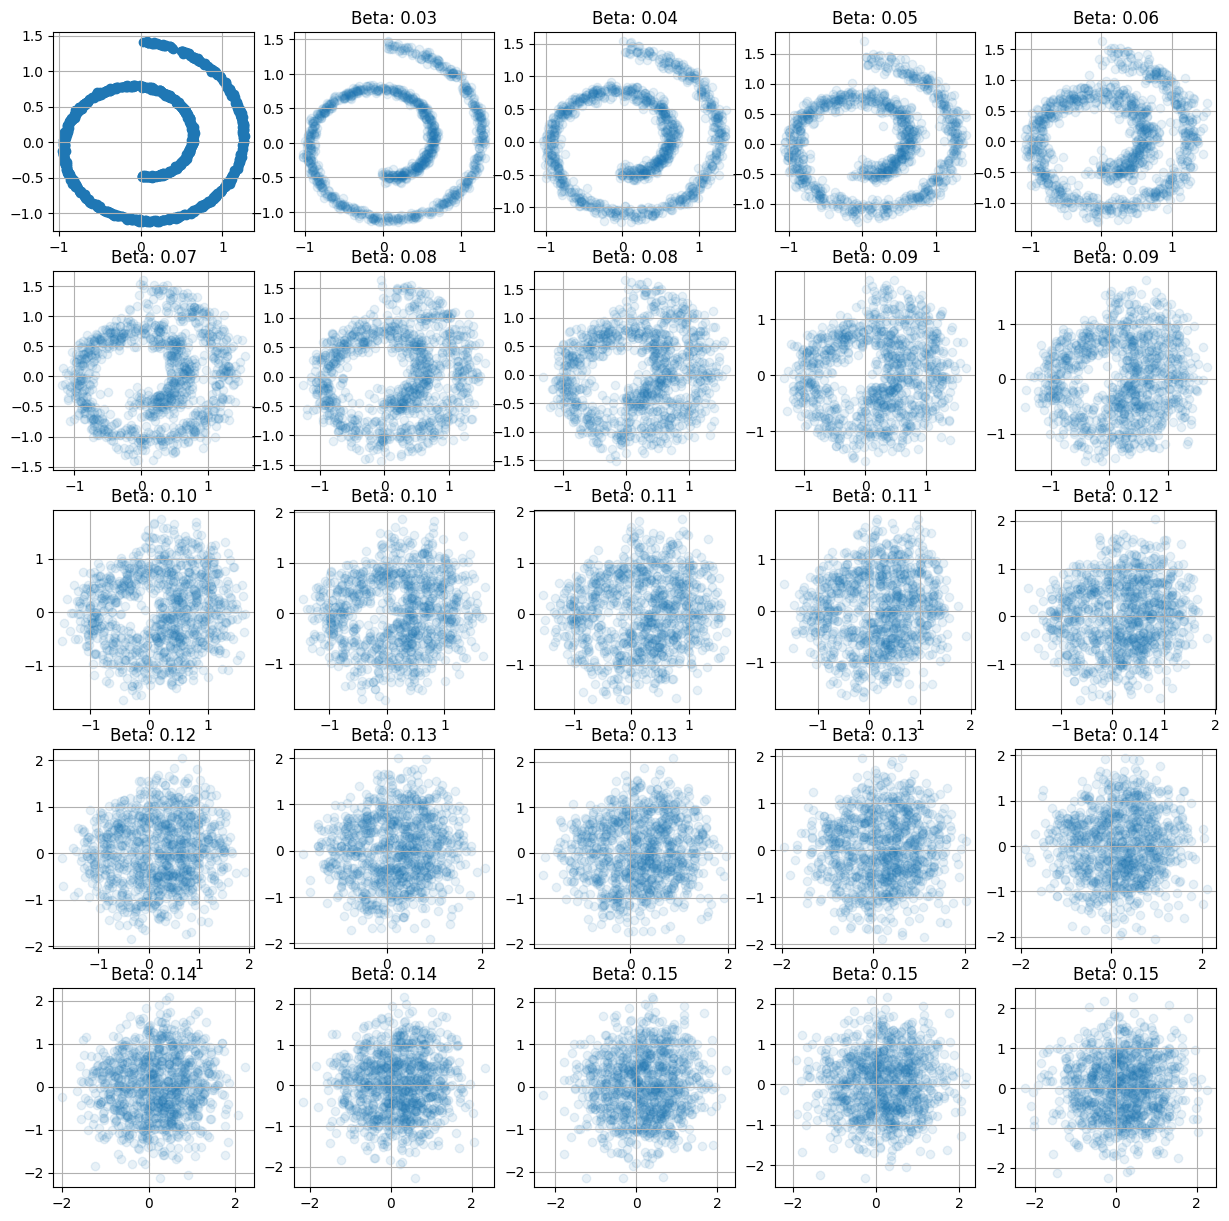

In [34]:
# Generate some test data
N = 1000
plt.figure(figsize=(15,15))
X = make_swiss_roll(n_samples=N, noise=1e-1)[0][:, [0, 2]] / 10.0
plt.subplot(5,5,1)
plt.scatter(X[:,0],X[:,1])
plt.grid()

# Slowly add noise
Xhat = X
steps = 1000
for j in range(1,25):
    Xhat = np.sqrt(1-j/steps)*Xhat + np.sqrt(j/steps)*np.random.randn(X.shape[0],X.shape[1])
    plt.subplot(5,5,j+1)
    plt.title('Beta: %2.2f'%np.sqrt(j/steps))
    plt.scatter(Xhat[:,0],Xhat[:,1],alpha=0.1)
    plt.grid()
plt.show()

This particular process has a nice property. We can sample an $x_t$ at any point in time in closed form using a reparametrisation trick.

Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha} = \prod_{i=0}^t \alpha_i$

then 

$$ x_t = \sqrt{\alpha_t} x_{t-1} + \sqrt{1-\alpha_t}\epsilon_{t-1}\, \text{where}\, \epsilon_{t-1} \sim \mathcal{N}(0,1)$$ 
$$ x_t = \sqrt{\alpha_t\alpha_{t-1}} x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\bar{\epsilon}_{t-2}\, \text{where}\, \bar{\epsilon_{t-2}} = \epsilon_{t-1}+\epsilon_{t-2} \sim \mathcal{N}(0,1)$$ 

Here, we use the fact that merging two independent standard Gaussians $\bar{\epsilon_{t-2}} = \epsilon_{t-1}+\epsilon_{t-2}$, results in another Gaussian, $\mathcal{N}(0,1)$. 

Continuing the above, we obtain:

$$ x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon$$

$$ q(x_t|x_0) = \mathcal{N}(x_t|\sqrt{\bar{\alpha}_t}x_0,1-\bar{\alpha_t})$$

This process allows us to obtain a distribution over $x_t$ after t steps or repeated noise addition.

#### Reverse process

Now, imagine that we could reverse this process $q(x_{t-1}|x_t)$, this would allow us to start with a random variable drawn from Gaussian noise, and eventually generate a sample $x_0$ from this.

To figure out how to do this, we'll start by looking at a related distribution, conditioned on $x_0$. By Bayes rule:

$$q(x_{t-1}|x_t,x_0) = q(x_{t}|x_{t-1},x_0)\frac{q(x_{t-1}|x_0)}{q(x_t|x_0)}$$

These are all Gaussians, and we know all these (see above), so by the product/division of exponents we can write this as:

$$ q(x_{t-1}|x_t,x_0) \propto \exp (-\frac{1}{2}( \frac{(x_t-\sqrt{\alpha_t}x_{t-1})^2}{\beta_t} + \frac{(x_{t-1}-\sqrt{\bar{\alpha}_{t-1}}x_{0})^2}{1-\bar{\alpha}_{t-1}} - \frac{(x_{t}-\sqrt{\bar{\alpha}_{t}}x_{0})^2}{1-\bar{\alpha}_{t}}))$$

This is another Gaussian, and with some non-trivial rearranging, we find that we can write this reverse process as a Gaussian transition, with mean $\mu(x_{t},x_0)$ and variance $\tilde{\beta}_t$.

$$ p_\theta(x_{t-1}|x_{t}) = \mathcal{N}(x_{t-1}|\mu(x_t,x_0),\tilde{\beta}_t) $$

$$ \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t $$

$$ \mu(x_{t},x_0) = \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0$$

But remember,

$$ x_0 = \frac{1}{\sqrt{\alpha_t}}(x_t-\sqrt{1-\bar{\alpha}_t} \epsilon_t) $$

So 

$$\mu_t = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}})\epsilon_t$$

which gives us the complete reverse process:

$$ q(x_{t-1}|x_{t}) = \mathcal{N}(x_{t-1}|\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}})\epsilon_t,\frac{1 - \bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t)$$

Most of the quantities here are known, except the noise term $\epsilon_t$. So lets train a neural network to predict the noise.

$$ p_\theta(x_{t-1}|x_{t}) = \mathcal{N}(x_{t-1}|\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}})\epsilon_\theta(x_t,t),\frac{1 - \bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t)$$


The equation above gives us a training objective. Given a sample $x_0$, and a sampled $t \sim U(0,T)$, we draw a starting noise $\epsilon \sim \mathcal{N}(0,1)$. We compute an $x_t$ and and $x_{t-1}$ using the forward process, predict $\epsilon_\theta(x_t,t)$, then take gradient steps to minimise the quantity

$$L_t = || x_{t-1} - \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}})\epsilon_\theta(x_t,t)||^2$$

[Ho et al. (2020)](https://arxiv.org/abs/2006.11239) decided to ignore the weighting, and just minimise the following instead, which apparently works better:
$$L_t = || \epsilon - \epsilon_\theta(x_t,t)||^2$$


So the general algorithm is, sample a random initial noise $\epsilon$, sample a random $t$ to jump ahead to, compute the forward process to get the noisy $x_t$. Get a neural network to predict the initial noise sample, conditioned on $x_t,t$. Once our model is trained, we can just run the reverse process using the model to predict the noise to be added, and eventually return a sample.

Sounds complex? All we're doing is repeatedly adding noise to data, and training a neural network to *undo* the noise.

#### Let's implement this in code

In [35]:
class DDPM(nn.Module):

    def __init__(self, n_steps, minval = 0.0001, maxval = 0.02):
        super().__init__()
        
        self.n_steps = n_steps

        self.beta = torch.linspace(minval, maxval, n_steps) # Our variance schedule
        self.alpha = 1 - self.beta 
        self.alpha_bar = torch.cumprod(self.alpha,dim=0) # cummulative product

    def diffusion_loss(self, model, x0,device='cpu'):
        
        batch_size = x0.shape[0]

        # Sample our initial noise
        eps = torch.randn_like(x0).to(device)

        # Sample a random time along the process
        t = torch.randint(0, self.n_steps, (batch_size,)).to(device)

        # compute the closed form noisy sample x_t after t time steps
        if len(x0.shape)>2:
            a_t = self.alpha_bar.to(device)[t][:, None,None,None]
        else:
            a_t = self.alpha_bar.to(device)[t][:, None]
       
        x_t = torch.sqrt(a_t)*x0 + torch.sqrt(1 - a_t)*eps
           
        # predict the noise added given time t and this noisy sample
        eps_pred = model(x_t, t)

        # Compute error between predicted noise and sampled noise
        return nn.MSELoss()(eps_pred, eps)

    #Reverse process
    def sample(self, model, n_samples,d_in=2,x=None,plot=False,device='cpu'): 
        model.eval()
        with torch.no_grad():

            # start off with an intial random set of samples
            if x == None:
                x = torch.randn(n_samples, d_in).to(device)

            for t in reversed(range(self.n_steps)):
                
                if len(x.shape)>2:
                    a = self.alpha[t].to(device).repeat(n_samples)[:, None,None,None]
                    abar = self.alpha_bar[t].to(device).repeat(n_samples)[:, None,None,None]
                    abar_1 = self.alpha_bar[t-1].to(device).repeat(n_samples)[:, None,None,None]
                else:
                    a = self.alpha[t].to(device).repeat(n_samples)[:, None]
                    abar = self.alpha_bar[t].to(device).repeat(n_samples)[:, None]
                    abar_1 = self.alpha_bar[t-1].to(device).repeat(n_samples)[:, None]

                # Use learned model to predict noise to apply to samples
                eps_theta = model(x, torch.tensor([t] * n_samples, dtype=torch.long).to(device))
                
                # Step process forward
               
                x_mean = 1/torch.sqrt(a)*(x - eps_theta*(1 - a)/torch.sqrt(1 - abar))
                sigma_t = torch.sqrt(self.beta[t]).to(device)
                
                # Note, the derivation above used the following uncertainty for the forward process
                # torch.sqrt((1-abar_1)/(1-abar)*(1-a))
                # but Ho 2020, found just using beta = 1-a is fine

                # sample a  new noise to add
                z = torch.randn_like(x).to(device)
                x = x_mean + sigma_t * z

                if plot:
                    plt.subplot(5,5,self.n_steps-t)
                    plt.scatter(X[:,0],X[:,1])
                    plt.quiver(x.detach().numpy()[:,0], x.detach().numpy()[:,1], -eps_theta[:,0].detach().numpy(),-eps_theta[:,1].detach().numpy())
                    plt.grid()
            model.train()
            return x_mean

#### We'll use a simple FCN to predict the noise (in the Ho et al. paper they use a more complex U-net)

In [36]:
class FCN(nn.Module):

    def __init__(self, d_in: int, d_out: int, d_hidden: int):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(d_in+8,d_hidden),
                                   nn.ReLU(),
                                   nn.Linear(d_hidden,d_hidden),
                                   nn.ReLU(),
                                   nn.Linear(d_hidden,d_out))

    def forward(self, x, t):
        # We will include time in our network using sinusoidal encoding
        time_encoding = (torch.hstack([torch.sin(t[:,None]*freq) for freq in [0, 2, 4, 8]]+[torch.cos(t[:,None]*freq) for freq in [0, 2, 4, 8]]))
        return self.model(torch.hstack([x,time_encoding]))

In [37]:
d_hidden = 128
d_in = d_out = X.shape[1]
batch_size = 128
n_epochs = 5000
n_steps = 25

# Make a noise prediction model, and diffusion process
model = FCN(d_in=2, d_hidden=d_hidden, d_out=2)
ddpm = DDPM(n_steps=n_steps)

optim = torch.optim.Adam(model.parameters(), 1e-2)

##### Let's train and visualise the generated samples as the noise prediction model learns

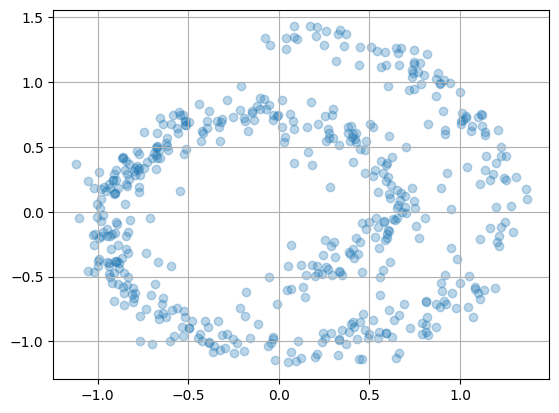

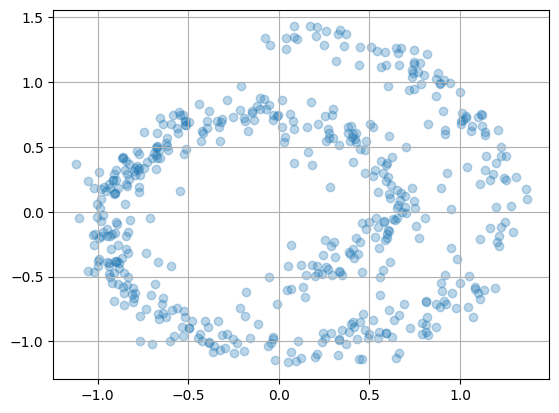

In [38]:
step = 0
avg_loss = None  # exponential moving average

with tqdm(total=n_epochs*(len(X)/batch_size)) as pbar:
    
    for _ in range(n_epochs):
    
        ids = np.random.choice(len(X), len(X)-batch_size, replace=False)
    
        for i in range(0, len(ids), batch_size):

            x = torch.tensor(X[ids[i:i +batch_size]], dtype=torch.float32)
            
            optim.zero_grad()
            loss = ddpm.diffusion_loss(model, x)
            loss.backward()
            optim.step()

            # Some visualisation during training.
            pbar.update(1)
            
            if avg_loss is None:
                avg_loss = loss.item()
            else:
                avg_loss = 0.95*avg_loss + 0.05*loss.item()
            if not step % 100:
                pbar.set_description(f"Iter: {step}. Average Loss: {avg_loss:.04f}")
                samples = ddpm.sample(model, n_samples=512)
                plt.cla()
                plt.scatter(samples.detach().numpy()[:,0],samples.detach().numpy()[:,1], alpha=0.3)
                plt.grid()
                
                display.clear_output(wait=True)
                display.display(plt.gcf())
            step += 1

#### Not bad, matches our input distribution. 

Remember the denoising diffusion model operates on a noise sample the same dimension of the data. In this case a 2d sample. It doesn't have to, and you could do this in a latent space too.

#### Noisy force fields

One way to interpret the diffusion process is as a series of vector fields that push particles to lie on the data distribution manifold. Let's take a look at this.

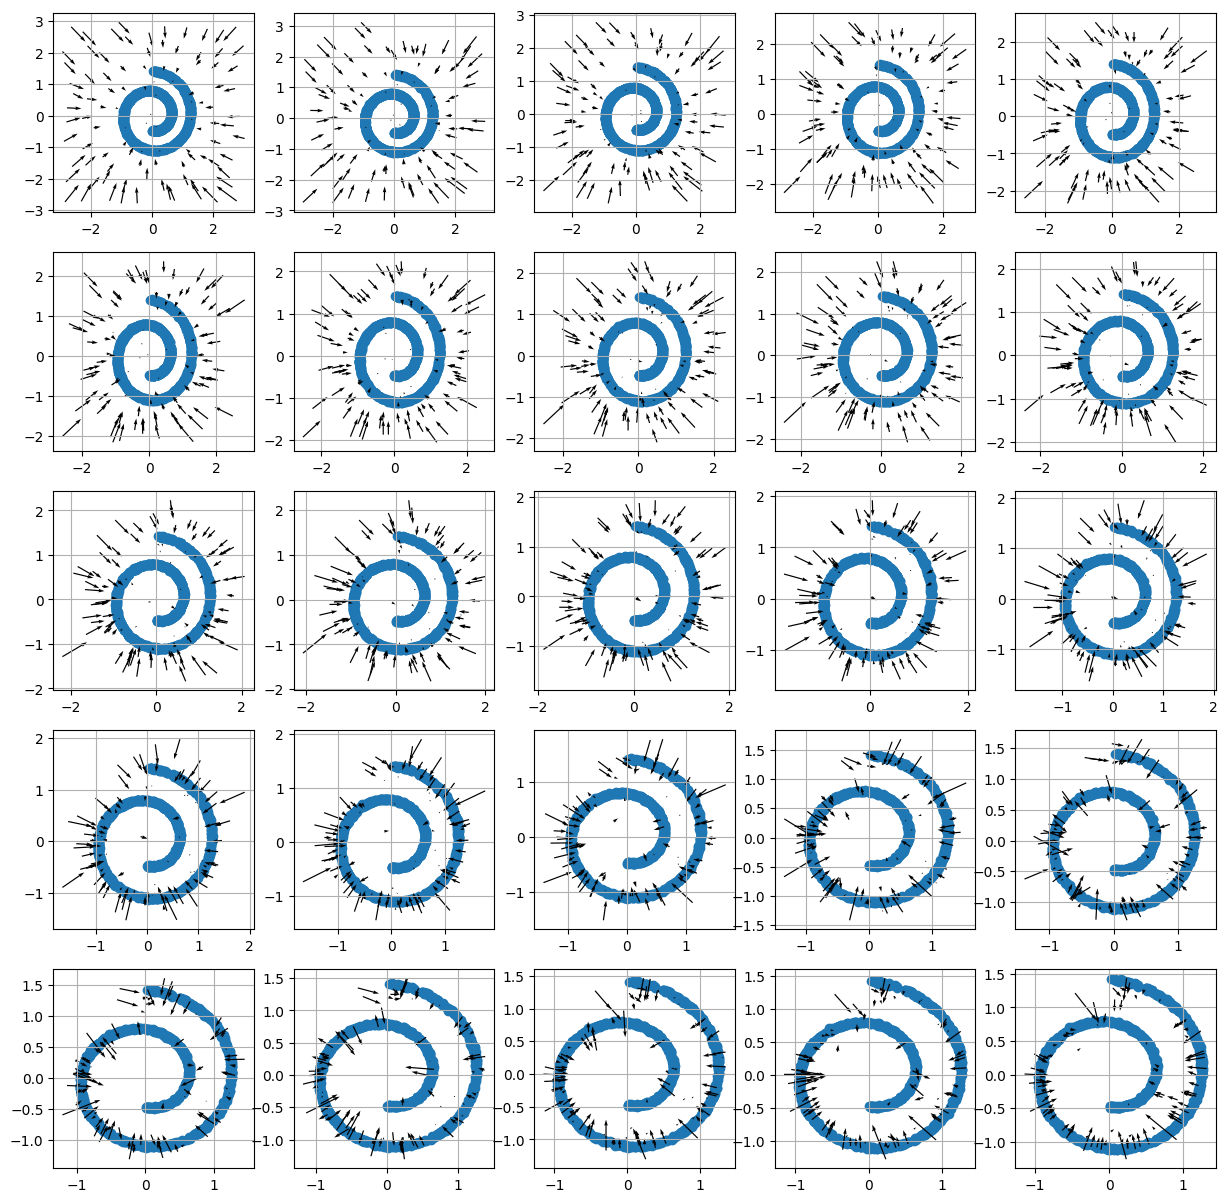

In [39]:
xs = torch.linspace(-3, 3, steps=10)
ys = torch.linspace(-3, 3, steps=10)
x, y = torch.meshgrid(xs, ys, indexing='xy')

plt.figure(figsize=(15,15))
xs = ddpm.sample(model,n_samples=100,x=torch.hstack([x.reshape(-1,1),y.reshape(-1,1)]),plot=True)
plt.show()

### Extending to images

Ok, this toy example just generates 2D points. Let's scale this up to generate full images! We'll replace the FCN with a unet and train a diffusion model to generate images using the CIFAR 10 dataset.

In [40]:
# Clear our GPU ram
torch. cuda. empty_cache()

In [41]:
n_epochs = 50
n_steps = 1000
ddpm = DDPM(n_steps=n_steps).to(device)

Let's pull a unet backbone from this nice [repo](https://github.com/pesser/pytorch_diffusion)
This is basically a standard unet, but with the addition of a time embedding so it takes arguments (im,t)

## How safe is this?

As we start to do more advanced things, we are relying on pre-existing models and code bases from seemingly random sources. We have historically had a *move fast and break things* culture in our field, but this is very problematic when your systems mature, and you start to run into issues. We often call this technical debt - bad or easy choices we make may come back to bite us down the line. For example:

* Licensing issues - these models may be subject to licenses that prevent their use in certain applications, or require them to be used subject to certain conditions (eg. free to use, as long as you make all code using these open source). You may be required to pay for some code bases in commercial applications.
* Security - can we trust that these models don't have malicious code embedded in them? 
* Ethical considerations - where did the data used to train these models come from, what is hidden inside them?

In [42]:
!pip3 install -e git+https://github.com/pesser/pytorch_diffusion.git#egg=pytorch_diffusion

Obtaining pytorch_diffusion from git+https://github.com/pesser/pytorch_diffusion.git#egg=pytorch_diffusion
  Updating /home/michael/Documents/Teaching/ECE4076/ECE4076/.venv/src/pytorch-diffusion clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 304bdff2196db604fb66108b0bb2d4a19058b20f
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pytorch_diffusion (pyproject.toml) ... done
  Created wheel for pytorch_diffusion: filename=pytorch_diffusion-0.0.1-0.editable-py3-none-any.whl size=4243 sha256=15dc6ee6932ba25dfdf1fca4991bed10fc3c8ce09a7adb6ca2ddbb0ee0bd352f
  Stored in directory: /tmp/pip-ephem-wheel-cache-brdmfuk8/wheels/4f/ca/26/788b1bdddd053c22c893103a2cf2f87aa823e25d625545b118
Successfully built pytorch_diffusion
  Attempting uninstall: pytorch_diffusion
    Found existing 

In [43]:
from pytorch_diffusion import Model

model = Model(resolution=32,
              in_channels=3,
              out_ch=3,
              ch=128,
              ch_mult=(1,2,2,2),
              num_res_blocks=2,
              attn_resolutions=(16,),
              dropout=0.1).to(device)

print(model)

Model(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList()
      (downsample): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      )
    )
    (1): Module(
      (block): ModuleList(
       

In [44]:

optim = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


data = torchvision.datasets.CIFAR10(root='./data/',transform=transform,download=True)
train_loader = DataLoader(data,batch_size=256,shuffle=True,num_workers=4)
losses = []
avg_loss = None  # exponential moving average
n_epochs = 100

Files already downloaded and verified


Training this yourself will take some time (a couple days).

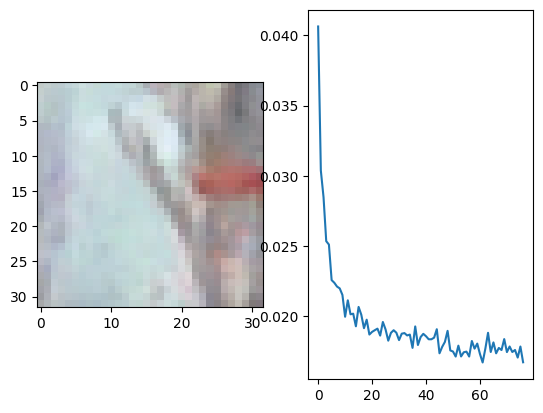

  0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
for step in range(n_epochs):

    t = tqdm(total=len(train_loader))

    for i,batch in enumerate(train_loader):
        im,_ = batch
        
        loss = ddpm.diffusion_loss(model, im.to(device),device=device)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # Some visualisation during training.
        t.update(1)
        
        if avg_loss is None:
            avg_loss = loss.item()
        else:
            avg_loss = 0.95*avg_loss + 0.05*loss.item()
        t.set_description(f"Iter: {step}. Average Loss: {avg_loss:.04f}")
    t.reset()
    losses.append(avg_loss)
        
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(np.clip((ddpm.sample(model,x=torch.randn(1,3,32,32).to(device),n_samples=1,device=device).transpose(1,3).detach().cpu().squeeze()),0,1))  
    plt.subplot(1,2,2)
    plt.plot(losses)
    display.clear_output(wait=True)
    display.display(plt.gcf())

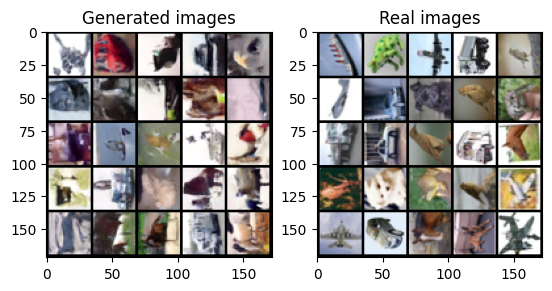

In [47]:
Ns = 25
ims = np.clip(ddpm.sample(model,x=torch.randn(Ns,3,32,32).to(device),n_samples=Ns,device=device).detach().cpu(),0,1)
grid_im = torchvision.utils.make_grid(ims, nrow=5).transpose(0,2)
plt.subplot(1,2,1)
plt.imshow(grid_im)
plt.title('Generated images')
grid_im = torchvision.utils.make_grid(im[0:25], nrow=5).transpose(0,2)
plt.subplot(1,2,2)
plt.imshow(grid_im)
plt.title('Real images')
plt.show()

Look at that - so much nicer than the GAN and VAE!

### Remember I made a promise in Week 1?

How can we make this faster and more computationally efficient? Well, we can play use some tricks in the noise schedule, we can play with the integration scheme used to rollout the noise field. 

Or, we can run the diffusion model in the latent space of an autoencoder, which is more efficient. If you combine a [VAE encoder + ViT + DDPM + VAE decoder](https://arxiv.org/abs/2212.09748) you get state of the art image generation. [OpenAI's SORA](https://openai.com/research/video-generation-models-as-world-simulators) video generation approach basically does this, but with the encoder acting on frame sequences. 

Interested in learning more - for a deep dive I recommend [Lilian Weng's blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).

